# Classification
## MSDS 7349 - Section 401
## Project 2

[Data Science @ Southern Methodist University](https://datascience.smu.edu/)

# Table of Contents
* [Team Members](#Team-Members)
* [Data Preparation](#Data-Preparation)
* [Dataset Description](#Dataset-Description)
* [Evaluation Metrics Description](#Evaluation-Metrics-Description)
* [Training and Testing Splits method](#Training-Testing)
* [Classification Task](#Classification-Task)
* [Regression Task](#Regression-Task)
* [Methods of Evaluation Results](#Methods-of-Evaluation)
* [Advantages of each model](#Advantages-of-each-model)
* [Relevant Attributes](#Relevant-Attributes)
* [Deployment](#Deployment)
* [Exceptional Work](#Exceptional-Work)
* [References](#References)


# <a name="Team-Members"></a>Team Members
* [Jostein Barry-Straume](https://github.com/josteinstraume)
* [Kevin Cannon](https://github.com/kcannon2)
* [Ernesto Carrera Ruvalcaba](https://github.com/ecarrerasmu)
* [Adam Tschannen](https://github.com/adamtschannen)

# <a name="Data-Preparation"></a>Data Preparation

[10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

> The credit default data set is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#). It has 30,000 records with 24 attributes. The records reflect the payment data from an important Taiwanese bank during October, 2005 (Yeh & Lien 2475).

> The purpose of the data set was to tackle the issue of forecasting the probability of default. In particular, the researchers of this data set sought to determine if the "estimated probability of default produced from data mining methods... (could) represent the "real" probability of default" (Yeh & Lien 2473).

> The dataset needs some pre-processing before it is ready for classification and regression analysis.

> To start, missing or incorrect values for education level, marital status, and repayment status are imputed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import statistics as st
import csv as csv
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from __future__ import print_function
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

#ignore warnings
import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline

filepath = "/data/credit-defaults.xls"

# Relative local path to avoid changing filepath constantly
credit = pd.read_excel('../data/credit-defaults.xls', header=1, skiprows=0)


# Rename column(s)
credit = credit.rename(columns={'default payment next month': 'default_next_m', 'PAY_0': 'PAY_1'})


In [2]:
#CREATING NEW VARIABLE TO IMPUTE THE VALUES TO 4, THAT REPRESENTS OTHER
credit['EDUCATION_INP']=credit['EDUCATION']

credit.loc[credit['EDUCATION'] > 4, 'EDUCATION_INP'] = 4
credit.loc[credit['EDUCATION'] == 0, 'EDUCATION_INP'] = 4

In [3]:
####FOR MARRIAGE
#CREATING NEW VARIABLE TO IMPUTE THE VALUES TO 2, THAT REPRESETNS SINGLE, since the value of 0 is not defined in
#the data dictionary
credit['MARRIAGE_INP']=credit['MARRIAGE']


credit.loc[credit['MARRIAGE'] == 0, 'MARRIAGE_INP'] = 2


In [4]:
########### CREATING A FUNCTION TO GROUP VARIABLES
def group_biv_v1(var_name,RangeName,CutOff,NumBins,BinLabel,var_x,var_y,title1,title2):
#def bivariate_v1(NumBins): 
    #Creating the BINS
    credit[RangeName]=pd.cut(var_name,CutOff,NumBins,labels=BinLabel)
    #Grouping by the BINS variable
    default_g=credit.groupby(by=[RangeName])
    #% of POPULATION
    bins_percentage=default_g[RangeName].count()/credit[RangeName].count()
    
    #### creating DUMMY VARIABLES
    
    
    
    

#group_biv_v1(credit.PAY_1,'PAY_1_range',[-2.1,0,1,10],3,['Pay duly','delay 1 month ','delay > 1'],'Percentage','PAY_1_bins','% of population PAY_1','Default PAY_1 ')


In [5]:
############## IMPUTE VALUES FOR THE VARIABLES OF REPAYMENT STATUS (PAY0, PAY1,   PAYN)
group_biv_v1(credit.PAY_1,'PAY_1_range',[-2.1,0,1,10],3,['Pay duly','delay 1 month ','delay > 1'],'Percentage','PAY_1_bins','% of population PAY_1','Default PAY_1 ')

group_biv_v1(credit.PAY_2,'PAY_2_range',[-2.1,1,10],2,['Pay duly','delay > 1'],'Percentage','PAY_2_bins','% of population PAY_2','Default PAY_2 ')

group_biv_v1(credit.PAY_3,'PAY_3_range',[-2.1,1,10],2,['Pay duly','delay > 1'],'Percentage','PAY_3_bins','% of population PAY_3','Default PAY_3 ')

group_biv_v1(credit.PAY_4,'PAY_4_range',[-2.1,1,10],2,['Pay duly','delay > 1'],'Percentage','PAY_4_bins','% of population PAY_4','Default PAY_4 ')

group_biv_v1(credit.PAY_5,'PAY_5_range',[-2.1,1,10],2,['Pay duly','delay > 1'],'Percentage','PAY_5_bins','% of population PAY_5','Default PAY_5 ')

group_biv_v1(credit.PAY_6,'PAY_6_range',[-2.1,1,10],2,['Pay duly','delay > 1'],'Percentage','PAY_6_bins','% of population PAY_6','Default PAY_6 ')


In [6]:
credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT6,default_next_m,EDUCATION_INP,MARRIAGE_INP,PAY_1_range,PAY_2_range,PAY_3_range,PAY_4_range,PAY_5_range,PAY_6_range
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,1,2,1,delay > 1,delay > 1,Pay duly,Pay duly,Pay duly,Pay duly
1,2,120000,2,2,2,26,-1,2,0,0,...,2000,1,2,2,Pay duly,delay > 1,Pay duly,Pay duly,Pay duly,delay > 1
2,3,90000,2,2,2,34,0,0,0,0,...,5000,0,2,2,Pay duly,Pay duly,Pay duly,Pay duly,Pay duly,Pay duly
3,4,50000,2,2,1,37,0,0,0,0,...,1000,0,2,1,Pay duly,Pay duly,Pay duly,Pay duly,Pay duly,Pay duly
4,5,50000,1,2,1,57,-1,0,-1,0,...,679,0,2,1,Pay duly,Pay duly,Pay duly,Pay duly,Pay duly,Pay duly


In [7]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 33 columns):
ID                30000 non-null int64
LIMIT_BAL         30000 non-null int64
SEX               30000 non-null int64
EDUCATION         30000 non-null int64
MARRIAGE          30000 non-null int64
AGE               30000 non-null int64
PAY_1             30000 non-null int64
PAY_2             30000 non-null int64
PAY_3             30000 non-null int64
PAY_4             30000 non-null int64
PAY_5             30000 non-null int64
PAY_6             30000 non-null int64
BILL_AMT1         30000 non-null int64
BILL_AMT2         30000 non-null int64
BILL_AMT3         30000 non-null int64
BILL_AMT4         30000 non-null int64
BILL_AMT5         30000 non-null int64
BILL_AMT6         30000 non-null int64
PAY_AMT1          30000 non-null int64
PAY_AMT2          30000 non-null int64
PAY_AMT3          30000 non-null int64
PAY_AMT4          30000 non-null int64
PAY_AMT5          30000 non-null 

In [8]:
#### CREATE DUMMY VARIABLES
#Convert Categorical fields to bool using get_dummies
#Use drop_first=true to aviod multicolinierarity
### The drop_first=true eliminates the first group of the dummy variable
### According to the notes provided of the professor we do this to prevent multicollinearity
#### I can see it in the context of regression and logistic regression. We may want to select the group to delet
##### The method "get_dummies" also ELIMINATES THE ORIGINAL VARIABLE TO CREATE THE dummies

#EC: Creating  another reference in MEMORY, so the changes in df will not be REFLECTED IN CREDIT
df = credit.copy()



df = pd.get_dummies(data=credit, 
                       columns=['EDUCATION_INP',
                                'MARRIAGE_INP', 
                                'PAY_1_range',
                                'PAY_2_range',
                                'PAY_3_range',
                                'PAY_4_range',
                                'PAY_5_range',
                                'PAY_6_range',
                                'SEX'], drop_first=True) #Try drop_first=true to aviod multicolinierarity







df.info()

df.head()


#credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 37 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_1                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1                

,ID,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,MARRIAGE_INP_2,MARRIAGE_INP_3,PAY_1_range_delay 1 month,PAY_1_range_delay > 1,PAY_2_range_delay > 1,PAY_3_range_delay > 1,PAY_4_range_delay > 1,PAY_5_range_delay > 1,PAY_6_range_delay > 1,SEX_2
0,1,20000,2,1,24,2,2,-1,-1,-2,...,0,0,0,1,1,0,0,0,0,1
1,2,120000,2,2,26,-1,2,0,0,0,...,1,0,0,0,1,0,0,0,1,1
2,3,90000,2,2,34,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,4,50000,2,1,37,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,50000,2,1,57,-1,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


> Next, additional variables are created to help with the regression and classification analysis. The following variables were created and added to the dataset:
* Average bill amount over the 6 month period
* Average payment amount over the 6 month period
* Ratio of average bill amount to credit limit balance
* Ratio of the average payment amount to credit limit balance

In [9]:
##### CREATING ADDITIONAL VARIABLES 

############## CREATING NEW VARIABLES

#Average of the bill amount
df['Avg_BILL']=(df['BILL_AMT1']+df['BILL_AMT2']+df['BILL_AMT3']+ df['BILL_AMT4']+df['BILL_AMT5']+df['BILL_AMT6']
               )/float(6)


#Average of the Payment amount

df['Avg_PAY']=(df['PAY_AMT1']+df['PAY_AMT2']+df['PAY_AMT3']+df['PAY_AMT4']+df['PAY_AMT5']+df['PAY_AMT6']
               )/float(6)

#We are constructing the ratio with the average BILL AMOUNT TO LIMIT
df['AvgBill_to_LIMIT_BAL']=(df['Avg_BILL']/df['LIMIT_BAL'])


#We are constructing the ratio with the  average PAYMENT AMOUNT TO LIMIT
df['AvgPay_to_LIMIT_BAL']=(df['Avg_PAY']/df['LIMIT_BAL'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 41 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_1                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1                

### Removing variables not needed in the analysis
>We will conduct one classification task and one regression task. We will create 2 different objects since we will remove different variables

> We first create the object for the classification task

In [10]:
### WE CREATE AN OBJECT FOR THE CLASSIFICATION TASK AND OTHER FOR THE REGRESSION TASK

# CREATING THE OBJECT FOR THE CLASSIFICATION TASK
class_t=df.copy()


if 'default_next_m' in class_t:
    y_c = class_t['default_next_m'].values
    del class_t['default_next_m']
    del class_t['ID']
    del class_t['EDUCATION']
    del class_t['MARRIAGE']
    del class_t['PAY_1']
    del class_t['PAY_2']
    del class_t['PAY_3']
    del class_t['PAY_4']
    del class_t['PAY_5']
    del class_t['PAY_6']
    X_c = class_t.values
    
    
    

> Then we create the object for the Regression Task

In [11]:
### WE CREATE AN OBJECT FOR THE CLASSIFICATION TASK AND OTHER FOR THE REGRESSION TASK

# CREATING THE OBJECT FOR THE REGRESSION  TASK

reg_t=df.copy()


if 'AvgBill_to_LIMIT_BAL' in reg_t:
    y_r = reg_t['AvgBill_to_LIMIT_BAL'].values
    del reg_t['AvgBill_to_LIMIT_BAL']
    del reg_t['ID']
    del reg_t['EDUCATION']
    del reg_t['MARRIAGE']
    del reg_t['PAY_1']
    del reg_t['PAY_2']
    del reg_t['PAY_3']
    del reg_t['PAY_4']
    del reg_t['PAY_5']
    del reg_t['PAY_6']
    del reg_t['Avg_BILL']
    del reg_t['LIMIT_BAL']
    del reg_t['AvgPay_to_LIMIT_BAL']
    del reg_t['BILL_AMT1']
    del reg_t['BILL_AMT2']
    del reg_t['BILL_AMT3']
    del reg_t['BILL_AMT4']
    del reg_t['BILL_AMT5']
    del reg_t['BILL_AMT6']
    X_r = reg_t.values

#len(y_r)
y_r
#reg_t.info()

array([ 0.0642    ,  0.02371806,  0.1882463 , ...,  0.39164444,
        0.55543958,  0.76958   ])

# <a name="Dataset-Description"></a>Dataset Description

>[5 points] Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

# <a name="Data-Meaning-Type"></a>Data Meaning Type
*Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.*

> The original dataset contains the following data types:

| Variable | Variable Type | Description |
| :------: | :-----------: | :----- |
| LIMIT_BAL | int64 | The amount of the given credit in New Taiwan dollars.<br/>It includes both the individual consumer credit and his/her family (supplementary) credit |
| SEX | int64 | Defines each subjects gender with:<ul><li>1 = Male</li><li>2 = Female</li></ul> |
| EDUCATION | int64 | Represents each subject level of education with:<ul><li>1 = Graduate School</li><li>2 = University</li><li>3 = High School</li><li>4 = Other</li></ul> |
| MARRIAGE | int64 | Defines the person's relationship status by:<ul><li>1 = Married</li><li>2 = Single</li><li>3 = Other</li></ul> |
| AGE | int64 | Defines how old each person is in years |
| PAY_0 | int64 | The repayment status in September, 2005 |
| PAY_2 | int64 | The repayment status in August, 2005 |
| PAY_3 | int64 | The repayment status in July, 2005 |
| PAY_4 | int64 | The repayment status in June, 2005 |
| PAY_5 | int64 | The repayment status in May, 2005 |
| PAY_6 | int64 | The repayment status in April, 2005 |
| BILL_AMT1 | int64 | The repayment status in September, 2005 |
| BILL_AMT2 | int64 | The repayment status in August, 2005 |
| BILL_AMT3 | int64 | The repayment status in July, 2005 |
| BILL_AMT4 | int64 | The repayment status in June, 2005 |
| BILL_AMT5 | int64 | The repayment status in May, 2005 |
| BILL_AMT6 | int64 | The repayment status in April, 2005 |
| PAY_AMT1 | int64 | The amount paid in September, 2005 |
| PAY_AMT2 | int64 | The amount paid in August, 2005 |
| PAY_AMT3 | int64 | The amount paid in July, 2005 |
| PAY_AMT4 | int64 | The amount paid in June, 2005 |
| PAY_AMT5 | int64 | The amount paid in May, 2005 |
| PAY_AMT6 | int64 | The amount paid in April, 2005 |
| default payment next month | int64 | A binary value indicating default status with:<ul><li>0 = Customer has defaulted</li><li>1 = Customer has not defaulted</li></ul>|

> The following table exhibit the name of the variables with imputed values and the dummy variables for the categorical variables.


| Variable | Variable Type | Description |
| :------: | :-----------: | :----- |
| EDUCATION_INP_2 | uint8 | Dummy variable for education - indicating university grade|
| EDUCATION_INP_3 | uint8| Dummy variable for education - indicating high school grade |
| EDUCATION_INP_4 | uint8 |  Dummy variable for education - indicating high school grade |
| MARRIAGE_INP_2 | uint8 |  Dummy variable for marital status - indicating married |
| MARRIAGE_INP_3 | uint8 | Dummy variable for marital status - indicating other |
| PAY_1_range_delay 1 month | uint8 | Dummy indicating 1 month delay for September, 2005 |
| PAY_1_range_delay > 1 | uint8 | Dummy indicating more than 2 month delay for September, 2005 |
| PAY_2_range_delay > 1  | uint8 | Dummy indicating more than 2 month delay for August, 2005 |
| PAY_3_range_delay > 1  | uint8 | Dummy indicating more than 2 month delay for July, 2005 |
| PAY_4_range_delay > 1  | uint8 | Dummy indicating more than 2 month delay for June, 2005 |
| PAY_5_range_delay > 1  | uint8 | Dummy indicating more than 2 month delay for May, 2005 |
| PAY_6_range_delay > 1  | uint8 | Dummy indicating more than 2 month delay for April, 2005 |
| SEX_2 | uint8 | Dummy variable for sex - indicating female|
| Avg_BILL | float64 | Average bill amount over the 6 month period |
| Avg_PAY | float64 | Average payment amount over the 6 month period|
| AvgBill_to_LIMIT_BAL | float64 | Ratio of average bill amount to credit limit balance |
| AvgPay_to_LIMIT_BAL | float64 | Ratio of the average payment amount to credit limit balance |




### Dataset Description for the classification task

> To complete the classification task, we removed columns: 'default_next_m', 'ID','EDUCATION', "MARRIAGE', and the payment status 'PAY_1 -PAY_6'. The remaining variables include age, payment amounts, default status for next month, the imputed values of education and marital status, delay in repayment status, sex, and average payment amount. The four new created variables, as mentioned above, were added to the classification dataset as well.

### Dataset Description for the Regression task

> To complete the regression task, several columns were removed: 'ID', 'EDUCATION', 'MARRIAGE', 'PAY_1' through 'PAY_6', 'Avg_BILL', 'LIMIT_BAL', 'AvgPay_to_LIMIT_BAL', and 'BILL_AMT1' through 'BILL_AMT6'. The remaining variables include age, payment amounts, default status for next month, the imputed values of education and marital status, delay in repayment status, sex, and average payment amount. Two of the four new created variables, 'Avg_PAY' and 'AvgBill_to_LIMIT_BAL', were added to the regression dataset.

# <a name="Evaluation-Metrics-Description"></a>Evaluation Metrics Description


>[10 points] Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

## Metrics for Evaluating Regression Models 

**All regression models created in this notebook are validated using the following metrics:**
* Mean Absolute Error (MAE) - https://www.quora.com/Are-there-instances-where-root-mean-squared-error-might-be-used-rather-than-mean-absolute-error
* Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
* Mean Absolute Percentage Error (MAPE) - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python

**For details on making scorers to return multiple mean error scores see:**
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
* https://github.com/scikit-learn/scikit-learn/pull/7388
* https://github.com/drorata/multiscorer

> The metrics mentioned above are appropriate for the Regression task since they measure the error of our model. We are calculating the 3 metrics since they can be used differently depending on the usage of the model,the underlying data and they all have specific drawbacks. 

>RMSE gives a relatively high weight to large errors. This means the RMSE is most useful when large errors are particularly undesirable. For example, let's consider the case of a nuts and bolts manufacturing company. If the width specifications of say, the bolts are 8mm +- 0.1 mm, then any nut that is manufactured by the company with deviation > 0.1 mm is useless. Thus, higher errors are far more undesirable than lower.

> One of the drawbacks of MAPE is that cannot be used if there are zero values (which sometimes happens for example in demand data) because there would be a division by zero.


## Metrics for Evaluating Classification Models 

**All classification models created in this notebook are validated using the following metric:**
* Recall - hhttp://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

>Recall is the ratio of correctly predicted positive observations to all observations in actual class 
>Recall is especially useful in the presence of unbalanced datasets (i.e. one category with very few observations). The proportion of defaulted borrowers is relatively low and therfore the recall is the metric deemed adequate to measure the performance of the classification task.  

# <a name="Training-Testing"></a>Training and Testing Splits method

>[10 points] Choose the method you will use for dividing your data into training and testing splits 
(i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is 
appropriate or use more than one method as appropriate. For example, 
if you are using time series data then you should be using continuous training and testing sets across time.


For classifications: We chose to use the stratified sampling method because our data contains a significantly high number of subjects classified as "0". Because of this imbalance, there is potential for the algorithm to predict a high number of true negatives and false negitives because of the class imbalance. The stratified cross validation procedure will ensure the training data sets will have approximately the same amount of subjects who defaulted as those who did not and will subsequently protect the algorithm against simpley predicting "0" everytime.

For regression: 

In [12]:
#### DEFINING THE CV OBJECT FOR CLASSIFICATION

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

num_cv_iterations = 10

cv_object = StratifiedShuffleSplit(n_splits = num_cv_iterations, 
                            test_size = 0.20, train_size = 0.80, random_state=1)


##### We generate the training and testing sample
for train_indices, test_indices in cv_object.split(X_c,y_c): 
    X_c_train = X_c[train_indices]
    y_c_train = y_c[train_indices]
    
    X_c_test = X_c[test_indices]
    y_c_test = y_c[test_indices]


#### SCALING THE OBJECTS
    


# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_c_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_c_train_scaled = scl_obj.transform(X_c_train) # apply to training
X_c_test_scaled = scl_obj.transform(X_c_test) # apply those means and std to the test set (without snooping at the test set values)
    
    
    
    
    



In [13]:
#### DEFINING THE CV OBJECT FOR REGRESSION

from sklearn.model_selection import ShuffleSplit
#cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)
#from sklearn.model_selection import StratifiedShuffleSplit

num_cv_iterations = 10

cv_reg = ShuffleSplit(n_splits = num_cv_iterations, 
                            test_size = 0.20, train_size = 0.80, random_state=1)


##### We generate the training and testing sample
for train_indices, test_indices in cv_reg.split(X_r,y_r): 
    X_r_train = X_r[train_indices]
    y_r_train = y_r[train_indices]
    
    X_r_test = X_r[test_indices]
    y_r_test = y_r[test_indices]
    
    
    
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj_r = StandardScaler()
scl_obj_r.fit(X_r_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_r_train_scaled = scl_obj_r.transform(X_r_train) # apply to training
X_r_test_scaled = scl_obj_r.transform(X_r_test) # apply those means and std to the test set (without snooping at the test set values)
    
    
    
    


#cv_reg

# <a name="Classification-Task"></a>Classification Task

> [20 points] Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

#### Classification Objective
> The purpose of the classification task will be to identify bad/delinquent borrowers in the bank's dataset.

## Random Forest Classification

In [14]:
# Source:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics as mt

depths = [1,2,3,4,5,6,7,8,9,10]

for depth in depths:
    clf = RandomForestClassifier(max_depth=depth, random_state=0, class_weight='balanced',
                                max_features='auto', n_estimators=100, bootstrap=True)
    model_rf = clf.fit(X_c_train, y_c_train)
    y_hat = clf.predict(X_c_test)

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_c_test,y_hat)
    conf = mt.confusion_matrix(y_c_test,y_hat)
    #print("accuracy", acc )
    print("confusion matrix\n",conf)

    print("\n *** CLASSIFICATION REPORT ****")
    print("\n *** Max Depths is", depth)
    #### CLASSIFICATION REPORT
    ClassReport = mt.classification_report(y_c_test,y_hat)
    print(ClassReport)



confusion matrix
 [[4111  562]
 [ 642  685]]

 *** CLASSIFICATION REPORT ****

 *** Max Depths is 1
             precision    recall  f1-score   support

          0       0.86      0.88      0.87      4673
          1       0.55      0.52      0.53      1327

avg / total       0.80      0.80      0.80      6000

confusion matrix
 [[4121  552]
 [ 646  681]]

 *** CLASSIFICATION REPORT ****

 *** Max Depths is 2
             precision    recall  f1-score   support

          0       0.86      0.88      0.87      4673
          1       0.55      0.51      0.53      1327

avg / total       0.80      0.80      0.80      6000

confusion matrix
 [[3960  713]
 [ 571  756]]

 *** CLASSIFICATION REPORT ****

 *** Max Depths is 3
             precision    recall  f1-score   support

          0       0.87      0.85      0.86      4673
          1       0.51      0.57      0.54      1327

avg / total       0.79      0.79      0.79      6000

confusion matrix
 [[3895  778]
 [ 557  770]]

 *** CLAS

In [15]:
print('Let\'s see our changing the class_weight parameter to None impacts the precision and recall:\n')
clf = RandomForestClassifier(max_depth=None, min_samples_split=2, random_state=0, class_weight=None,
                             max_features='auto', n_estimators=100, bootstrap=True)
model_rf = clf.fit(X_c_train, y_c_train)
y_hat = clf.predict(X_c_test)

# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(y_c_test,y_hat)
conf = mt.confusion_matrix(y_c_test,y_hat)
#print("accuracy", acc )
print("Confusion matrix\n",conf)

print("\n *** CLASSIFICATION REPORT ****")
#### CLASSIFICATION REPORT
ClassReport = mt.classification_report(y_c_test,y_hat)
print(ClassReport)

Let's see our changing the class_weight parameter to None impacts the precision and recall:

Confusion matrix
 [[4415  258]
 [ 848  479]]

 *** CLASSIFICATION REPORT ****
             precision    recall  f1-score   support

          0       0.84      0.94      0.89      4673
          1       0.65      0.36      0.46      1327

avg / total       0.80      0.82      0.79      6000



> By incrementally increasing the max_depths parameter we can see how the recall of the Random Forest classification model can be improved, albeit at the cost of precision. Around max_depths of 5 is when the decrease of precision outweighs the marginal increase in recall. Consequently, we will move on to adjusting parameters with a max_depths value of 5.

> It appears that changing the class_weight parameter from 'balanced' to None detrimentally impacts the recall of classifying who is and isn't going to default on their credit. The input parameter for class_weight will remain as 'balanced.'

In [17]:
clf = RandomForestClassifier(max_depth=5, min_samples_split=2, random_state=0, class_weight='balanced',
                             max_features='auto', n_estimators=500, bootstrap=True)
model_rf = clf.fit(X_c_train, y_c_train)
y_hat = clf.predict(X_c_test)

# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(y_c_test,y_hat)
conf = mt.confusion_matrix(y_c_test,y_hat)
print("Confusion matrix\n",conf)

print("\n *** CLASSIFICATION REPORT ****")
#### CLASSIFICATION REPORT
ClassReport = mt.classification_report(y_c_test,y_hat)
print(ClassReport)

Confusion matrix
 [[3873  800]
 [ 548  779]]

 *** CLASSIFICATION REPORT ****
             precision    recall  f1-score   support

          0       0.88      0.83      0.85      4673
          1       0.49      0.59      0.54      1327

avg / total       0.79      0.78      0.78      6000



> After much tinkering, the model that offers the best balance between precision and recall involves the following input parameters:

* Max depths of 5
* Min_samples_split of 2
* Balanced class_weight
* 500 n_estimators

In [18]:
# View a list of the features and their importance scores
# Source:
# http://www.markhneedham.com/blog/2017/06/16/scikit-learn-random-forests-feature-importance/
# https://chrisalbon.com/machine_learning/trees_and_forests/random_forest_classifier_example/

from tabulate import tabulate
headers = ['name', 'score']
values = sorted(zip(class_t.columns, model_rf.feature_importances_), key=lambda x: x[1] * -1)
rf_feature_importance = tabulate(values, headers, tablefmt="plain")
print(rf_feature_importance)

ModuleNotFoundError: No module named 'tabulate'

## KNN Classification

In [23]:
from sklearn.neighbors.nearest_centroid import NearestCentroid

#checking for the best distance measurment
for d in ['l1','l2','cosine']:
    clf = NearestCentroid(metric=d)
    clf.fit(X_c_train, y_c_train)
    KNNyhat2 = clf.predict(X_c_test)
    KNNacc2 = mt.accuracy_score(y_c_test,KNNyhat2)
    print('\nAccuracy of', d, 'metrics is', KNNacc2 * 100, '%')   

print('\nThe beast measurment of distance is cosine')


Accuracy of l1 metrics is 52.6333333333 %

Accuracy of l2 metrics is 53.6 %

Accuracy of cosine metrics is 54.4666666667 %

The beast measurment of distance is cosine


/Users/atschannen/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "


In [24]:
from sklearn.neighbors import KNeighborsClassifier

max_accs3 = 0
max_k3 = 0

#checking or the best number of neighbors
for k in range(1,10):
    clf = KNeighborsClassifier(n_neighbors=k, weights='uniform', metric='cosine')
    clf.fit(X_c_train, y_c_train)
    KNNyhat3 = clf.predict(X_c_test)
    KNNacc3 = mt.accuracy_score(y_c_test,KNNyhat3)
    if max(max_accs3, KNNacc3) == KNNacc3:
        max_accs3 = KNNacc3
        max_k3 = k
        print('Accuracy of', k, 'neighbors is', KNNacc3 * 100, '%')

print('\nThe best accuracy is %f with %d neighbor(s)'%(max_accs3,max_k3))



Accuracy of 1 neighbors is 69.9333333333 %
Accuracy of 2 neighbors is 76.5333333333 %
Accuracy of 4 neighbors is 77.65 %
Accuracy of 8 neighbors is 78.0833333333 %

The best accuracy is 0.780833 with 8 neighbor(s)


In [25]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from IPython.html import widgets 
from sklearn.metrics import accuracy_score 
from sklearn import metrics as mt



#the below KNN model has been adjusted to have 8 nearest neighbors and its using the distance metric 'cosine' to measure
#for k in range():
clf = KNeighborsClassifier(n_neighbors=8, weights='uniform', metric='cosine')
clf.fit(X_c_train, y_c_train)
KNNyhat = clf.predict(X_c_test)
KNNacc = mt.accuracy_score(y_c_test,KNNyhat)

print('Accuracy of 8 neighbors is', KNNacc * 100)

# now let's get the accuracy and confusion matrix for this iterations of training/testing
print("confusion matrix\n",conf)

print("\n *** CLASSIFICATION REPORT ****")
#### CLASSIFICATION REPORT
ClassReportKNN = mt.classification_report(y_c_test,KNNyhat)
print(ClassReportKNN)

KNNrecall2 = mt.recall_score(y_c_test,KNNyhat2)
print('recall is:',KNNrecall2)


/Users/atschannen/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/atschannen/anaconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Accuracy of 8 neighbors is 78.0833333333
confusion matrix
 [[3873  800]
 [ 548  779]]

 *** CLASSIFICATION REPORT ****
             precision    recall  f1-score   support

          0       0.79      0.97      0.87      4673
          1       0.52      0.11      0.18      1327

avg / total       0.73      0.78      0.72      6000

recall is: 0.598342125094


For the KNN classification we used the classification report to measure how well the model performed. We found the best KNN model used the cosine distance metric and used 8 nearest neighbors. It had an average precision of .73 which means 73% of the time it is correctly classifying the observation correctly. This model had an average recall of .78 which means it has the ability to classify all of the positives samples at 78%. Finally it had an F1 score or .72 which shows this is a relatively strong model because the F1 score weighs all data points equally. Since by chance there is a 50% chance of classifying a subject correctly, this model would be useful to help better correctly classify someone to see if they will default or not.

## Logistic Regression Classification

In [122]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from time import time


#lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
lr_clf = LogisticRegression()

#class_weight='balanced'

parameters = {'penalty':('l1','l2'),'C':[1],'class_weight': ['balanced',None]}

#parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}
#'kernel':('linear', 'rbf')

#
'''
parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced',None]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }
'''


#'accuracy'

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
LogregGridSearch = GridSearchCV(estimator=lr_clf
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds = 10
                   , scoring='recall')

#Perform hyperparameter search to find the best combination of parameters for our data
#regGridSearch.fit(X_r, y_r)
LogregGridSearch.fit(X_c, y_c)


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   33.1s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1, test_size=0.2,
            train_size=0.8),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': [1], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

In [123]:
#Print the parameterization of the best estimator
LogregGridSearch.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [124]:
### WE RUN A LOGISTIC REGRESSION WITH THE BEST CONFIGURATION

#We set to the best regression configuration obtained
LogregEstimator = LogregGridSearch.best_estimator_



LogregEstimator.fit(X_c_train,y_c_train)  # train object

y_c_hat = LogregEstimator.predict(X_c_test) # get test set precition


In [125]:
def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation - it had X_highSchools and Y, I am going to change it to X and y
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

In [126]:
#We set to the best regression configuration obtained
LogregEstimator = LogregGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
#EvaluateRegressionEstimator(regEstimator, X_r, y_r, cv_reg)
EvaluateClassifierEstimator(LogregEstimator, X_c, y_c, cv_object)

The average accuracy for all cv folds is: 			 0.6398
The average precision for all cv folds is: 			 0.36476
The average recall for all cv folds is: 			 0.65863
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.542000,0.287974,0.727204
1,0.774333,0.490239,0.510927
2,0.695000,0.389548,0.668425
3,0.572167,0.301663,0.710625
4,0.559333,0.292468,0.699322
5,0.784500,0.512057,0.544084
6,0.562000,0.292239,0.689525
7,0.591833,0.316547,0.729465
8,0.764667,0.474566,0.597589
9,0.552167,0.290253,0.709118


## Feature Importance for Logistic Regression

>In this section, we will identify the most important factors based upon the magnitude of the coefficient in the logistic regression. For that purpose, we will standardize the variables to eliminate the fact of having variables in different scales.

In [127]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
#scl_obj = StandardScaler()
#scl_obj.fit(X_c_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

#X_train_scaled = scl_obj.transform(X_train) # apply to training
#X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
#lr_clf = LogisticRegression(penalty='l2', C=1, class_weight='balanced') # get object, the 'C' value is less (can you guess why??)



LogregEstimator.fit(X_c_train_scaled, y_c_train)

#lr_clf.fit(X_train_scaled,y_train)  # train object

y_c_hat = LogregEstimator.predict(X_c_test_scaled) # get test set precitions

#recall = mt.recall_score(y_c_test,y_c_hat)
#conf = mt.confusion_matrix(y_c_test,y_c_hat)
#print('Recall:', recall )
#print(conf)

# sort these attributes and spit them out
zip_vars = zip(LogregEstimator.coef_.T,class_t.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

BILL_AMT1 has weight of -0.22589298062979066
LIMIT_BAL has weight of -0.1924295056061685
PAY_AMT1 has weight of -0.17583965286014672
EDUCATION_INP_4 has weight of -0.11301917019286645
PAY_AMT2 has weight of -0.0868317352554969
Avg_PAY has weight of -0.0865954163142371
SEX_2 has weight of -0.08142093569480992
MARRIAGE_INP_2 has weight of -0.08068954661572847
BILL_AMT6 has weight of -0.0482536503305393
AvgBill_to_LIMIT_BAL has weight of -0.041314829981183715
BILL_AMT4 has weight of -0.03688929128250718
PAY_AMT3 has weight of -0.021724781397046783
BILL_AMT5 has weight of -0.016407356765247225
PAY_AMT5 has weight of -0.010175574475913612
EDUCATION_INP_3 has weight of -0.007417132681260596
PAY_AMT6 has weight of -0.0010321213250413636
MARRIAGE_INP_3 has weight of 0.00010904450010044442
PAY_AMT4 has weight of 0.0029239544677827378
Avg_BILL has weight of 0.007059020693161387
AvgPay_to_LIMIT_BAL has weight of 0.007890234063440712
EDUCATION_INP_2 has weight of 0.008424166995491283
AGE has weigh

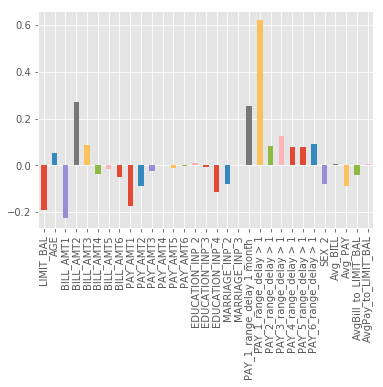

In [128]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#it had df.columns
weights = pd.Series(LogregEstimator.coef_[0],index=class_t.columns)
weights.plot(kind='bar')
plt.show()

>The most important variables to predict the default according to the logistic regression are:


>a) The repayment status of the most recent month (dummy variables: Pay_1_range_delay 1 month, Pay_1_rande delay < 1)

>b) The amount of bill statement of the most recent month (BILL_AMT1)

>c) Limit Balance (LIMIT_BAL)

>d) The amount paid in the most recent month (PAY_AMT1)

>Among the socio-economic variables (Sex, Education, Marriage, and Age), the Education is the most relevant, followed by Marriage, sex, and age.


# <a name="Regression-Task"></a>Regression Task

>[20 points] Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

#### Regression task Objective
> The purpose of the regression task will be to predict the ratio: "Ratio of average bill amount to credit limit balance".  That will give the bank the ability to target customers with very low usage of their credit and offer them additional products and conversely identify customers that are close to use total balance limit to monitor theri behavior and allocate capital for potendial defaults.

> We first build the code to measure the performance metrics for the regression task. The code is extracted from:
* http://localhost:8888/notebooks/Documents/Master%20Data%20Science/DataMining/EducationNC_Project/Graduation%20Rates%20v2%20(1).ipynb

In [129]:
##### SETTING UP THE PERFORMANCE METRICS
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               } 

## Regression Model Evaluation
** All regression models are evaluated using the regression model evaluation function below: ** 
* The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.
* The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.
* Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calculated using a single call to cross_validate().
* All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train CV data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over. 

In [130]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

## Baseline Regression Model

**Linear Regression is used to create a baseline model.  Since linear regression may predict response variable values outside the range of the training data's response variable, we create a linear regression estimator with minority percentage predictions clipped 0% and 100%. For details see:**
* http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator 
* https://github.com/scikit-learn/scikit-learn/issues/6950
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [131]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 100) 

### Linear Regression Grid Search
** Here we perform a grid search testing 40 models to find the best parameters for our Linear Regression model based on Mean Absolute Error.  See more on parameter tuning with grid search here:**
* http://scikit-learn.org/stable/modules/grid_search.html

In [132]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_reg # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
#regGridSearch.fit(X_r, y_r)
regGridSearch.fit(X_r, y_r)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.6s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=1, test_size=0.2, train_size=0.8),
       error_score='raise',
       estimator=CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=1,
            normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [133]:
#Print the parameterization of the best estimator
regGridSearch.best_estimator_

CappedLinearRegression(copy_X=True, fit_intercept=False, n_jobs=1,
            normalize=True)

##  Baseline Regression Model - Cross Validation
**Perform tenfold cross validation using the grid search "best" parameters and our Capped Linear Regression estimator**
* 10-fold cross-validation using the parameters for the top performing model 
* CAP predictions between 0 and 100% 
* Evaluate cross-validation results using MAE, MAPE, and RMSE

In [135]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
import warnings
warnings.filterwarnings('ignore')

regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
#EvaluateRegressionEstimator(regEstimator, X_r, y_r, cv_reg)
EvaluateRegressionEstimator(regEstimator, X_r, y_r, cv_reg)


The average MAE for all cv folds is: 			 0.27795
The average MAE percentage (MAPE) for all cv folds is: 	 440.93
The average RMSE for all cv folds is: 			 0.33199
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,0.280974,1626.461378,0.336603
1,0.275041,-776.651246,0.324731
2,0.276983,-1353.791854,0.329080
3,0.276121,1642.440461,0.327817
4,0.277215,1142.015559,0.328727
5,0.275749,20.446140,0.328822
6,0.280816,-498.179496,0.334812
7,0.279137,363.747926,0.340738
8,0.277709,926.656446,0.329714
9,0.279714,1316.172201,0.338904


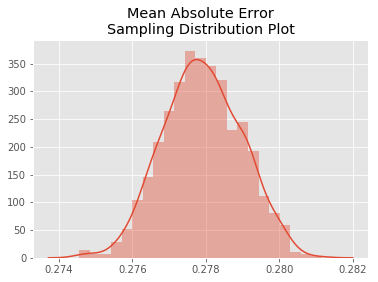

The mean of the distribution is 0.277910288411143
The median of the distribution is 0.27788907656506906


In [137]:
#Build a sampling distribution of the MAE via bootstrap
# - 1000 random samples with replacement  
# - Look at dist plot for the 1000 MAE's  
from sklearn.utils import resample
import seaborn as sns

# train on all of the data
regEstimator.fit(X_r, y_r)

maeList = []  # an empty list for MAE
sampleCt = len(y_r) # large same equal to validation set size, but w/ replacement!
y_r_hatMin = 0
y_r_hatMax = 0

for i in range(1000): # 1,000 samples
    X_r_samp, y_r_samp = resample(X_r, y_r, replace=True, n_samples=sampleCt)
    y_r_hat = regEstimator.predict(X_r_samp)
    mae = mean_absolute_error(y_r_samp, y_r_hat)
    maeList.append(mae)
    y_r_hatMin = np.minimum(y_r_hat.min(), y_r_hatMin)
    y_r_hatMax = np.maximum(y_r_hat.max(), y_r_hatMax)

#Print distributions for MAE
sns.distplot(maeList).set_title("Mean Absolute Error\nSampling Distribution Plot")  
plt.show()
plt.savefig('MAE_CAPPED')

print("The mean of the distribution is {mean}".format(mean=np.mean(maeList)))
print("The median of the distribution is {median}".format(median=np.median(maeList)))

## Multiple Linear Regression Feature Importance - Capped Regression


In [166]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_r)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_r_scl = scaler.transform(X_r)

In [167]:
#linreg_fi = linreg_clf.best_estimator_
regEstimator_fi = regGridSearch.best_estimator_

#Fit the model using all of our scaled data
regEstimator_fi.fit(X_r_scl, y_r)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='lsqr', tol=0.0001)

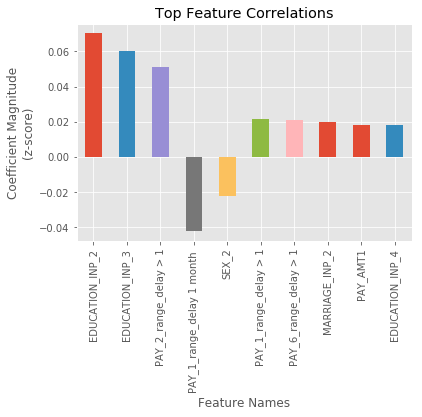

In [168]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = regEstimator_fi.coef_
#### WARNING HERE
feature_names = reg_t.columns
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(10)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar')

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

##  Lasso Regression
**Perform regression using Linear Model trained with L1 prior as regularizer (aka the Lasso)**

Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [169]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

lassoreg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=lassoreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_reg # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_r, y_r)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    3.0s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=1, test_size=0.2, train_size=0.8),
       error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': [0.001, 0.1, 1, 10, 20], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [170]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=True)

In [171]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_r, y_r, cv_reg)

The average MAE for all cv folds is: 			 0.31171
The average MAE percentage (MAPE) for all cv folds is: 	 -379.45
The average RMSE for all cv folds is: 			 0.353
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,0.312945,1968.562203,0.357046
1,0.310933,-557.090559,0.349272
2,0.310459,-2133.992640,0.350454
3,0.309206,821.386470,0.346295
4,0.312353,-848.455682,0.352686
5,0.307881,-2452.067162,0.348565
6,0.313857,-1264.995682,0.355773
7,0.315162,548.224661,0.361312
8,0.311389,-1114.752323,0.350986
9,0.312897,1238.684465,0.357586


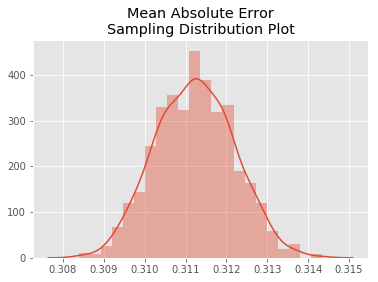

The mean of the distribution is 0.31122879667231756
The median of the distribution is 0.3112253441093979


In [172]:
#Build a sampling distribution of the MAE via bootstrap
# - 1000 random samples with replacement  
# - Look at dist plot for the 1000 MAE's  
from sklearn.utils import resample
import seaborn as sns

# train on all of the data
regEstimator.fit(X_r, y_r)

maeList = []  # an empty list for MAE
sampleCt = len(y_r) # large same equal to validation set size, but w/ replacement!
y_r_hatMin = 0
y_r_hatMax = 0

for i in range(1000): # 1,000 samples
    X_r_samp, y_r_samp = resample(X_r, y_r, replace=True, n_samples=sampleCt)
    y_r_hat = regEstimator.predict(X_r_samp)
    mae = mean_absolute_error(y_r_samp, y_r_hat)
    maeList.append(mae)
    y_r_hatMin = np.minimum(y_r_hat.min(), y_r_hatMin)
    y_r_hatMax = np.maximum(y_r_hat.max(), y_r_hatMax)

#Print distributions for MAE
sns.distplot(maeList).set_title("Mean Absolute Error\nSampling Distribution Plot")  
plt.show()
plt.savefig('MAE_LASSO')

print("The mean of the distribution is {mean}".format(mean=np.mean(maeList)))
print("The median of the distribution is {median}".format(median=np.median(maeList)))

In [173]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_r)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analysis 
X_r_scl = scaler.transform(X_r)

In [174]:
#linreg_fi = linreg_clf.best_estimator_
regEstimator_fi = regGridSearch.best_estimator_

#Fit the model using all of our scaled data
regEstimator_fi.fit(X_r_scl, y_r)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=True)

In [175]:
#Do we predict Average Bill amount to card Limit Balance ratios greater than 100%?
regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=True)

regEstimator.fit(X_r, y_r)
yhat = regEstimator.predict(X_r)
print("Yhat Max: ", yhat.max())

Yhat Max:  0.3730479457526812


##  Ridge Regression
**Perform regression using Linear least squares with l2 regularization**

Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [176]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

ridgereg = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=ridgereg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_reg # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_r, y_r)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:   11.2s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=1, test_size=0.2, train_size=0.8),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='auto', tol=0.0001),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20], 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [177]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='lsqr', tol=0.0001)

In [178]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_r, y_r, cv_reg)

The average MAE for all cv folds is: 			 0.27825
The average MAE percentage (MAPE) for all cv folds is: 	 351.59
The average RMSE for all cv folds is: 			 0.32815
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,0.280175,1662.023074,0.332624
1,0.276132,-539.584402,0.321971
2,0.278355,-1255.239839,0.326401
3,0.276066,1338.978267,0.322782
4,0.277515,810.626879,0.324810
5,0.275993,-233.839916,0.324786
6,0.280331,-612.434324,0.330710
7,0.279359,442.836824,0.336359
8,0.278508,641.759902,0.326381
9,0.280114,1260.757413,0.334655


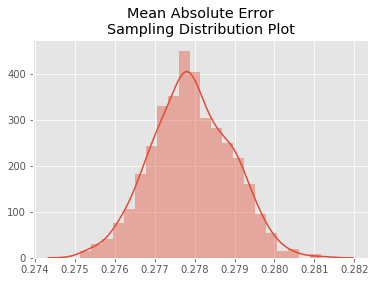

The mean of the distribution is 0.2779122934778619
The median of the distribution is 0.27786561455616254


In [179]:
#Build a sampling distribution of the MAE via bootstrap
# - 1000 random samples with replacement  
# - Look at dist plot for the 1000 MAE's  
from sklearn.utils import resample
import seaborn as sns

# train on all of the data
regEstimator.fit(X_r, y_r)

maeList = []  # an empty list for MAE
sampleCt = len(y_r) # large same equal to validation set size, but w/ replacement!
y_r_hatMin = 0
y_r_hatMax = 0

for i in range(1000): # 1,000 samples
    X_r_samp, y_r_samp = resample(X_r, y_r, replace=True, n_samples=sampleCt)
    y_r_hat = regEstimator.predict(X_r_samp)
    mae = mean_absolute_error(y_r_samp, y_r_hat)
    maeList.append(mae)
    y_r_hatMin = np.minimum(y_r_hat.min(), y_r_hatMin)
    y_r_hatMax = np.maximum(y_r_hat.max(), y_r_hatMax)

#Print distributions for MAE
sns.distplot(maeList).set_title("Mean Absolute Error\nSampling Distribution Plot")  
plt.show()
plt.savefig('MAE_RIDGE')

print("The mean of the distribution is {mean}".format(mean=np.mean(maeList)))
print("The median of the distribution is {median}".format(median=np.median(maeList)))

In [180]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_r)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analysis 
X_r_scl = scaler.transform(X_r)

In [181]:
#linreg_fi = linreg_clf.best_estimator_
regEstimator_fi = regGridSearch.best_estimator_

#Fit the model using all of our scaled data
regEstimator_fi.fit(X_r_scl, y_r)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='lsqr', tol=0.0001)

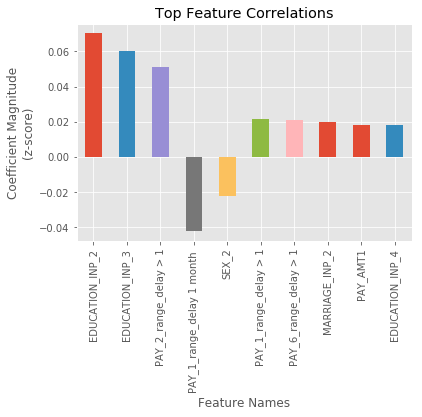

In [182]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = regEstimator_fi.coef_
#### WARNING HERE
feature_names = reg_t.columns
ridgereg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
ridgereg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = ridgereg_ft_imp_df.head(10)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar')

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

#ridgereg_ft_imp_df.info()
#ridgereg_ft_imp_df.head(22)

In [183]:
#Do we predict Average Bill amount to card Limit Balance ratios greater than 100%?
regEstimator = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='saga', tol=0.0001)

regEstimator.fit(X_r, y_r)
yhat = regEstimator.predict(X_r)
print("Yhat Max: ", yhat.max())

Yhat Max:  2.210585165977931


# <a name="Methods-of-Evaluation"></a>Methods of Evaluation Results

> [10 points] Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.




### Evaluation Results for Classification Problem

> Using the best configuration for each of the 3 algorithms explored (Random forest, KNN neighbors, and Logistic Regression), we will run 10 CV folds and calculate the recall to get a general sense of the distribution of the recall metric for each of the algorithms. 


In [ ]:
####### CREATE 10 FOLDS for the LOGISTIC REGRESSION with the corresponding recalls

### WE RUN A LOGISTIC REGRESSION WITH THE BEST CONFIGURATION

#We set to the best regression configuration obtained
LogregEstimator = LogregGridSearch.best_estimator_




from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

scoring = ['precision_macro', 'recall_macro']
#clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores_M1 = cross_validate(LogregEstimator, X_c, y_c, scoring=scoring,
                         cv=10, return_train_score=False)
sorted(scores_M1.keys())
#['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']
scores_M1['test_recall_macro']                       


In [ ]:
######### CREATE 10 FOLDS for the KNN NEIGHBORS with the corresponding recalls

clf_KNN = KNeighborsClassifier(n_neighbors=8, weights='uniform', metric='cosine')
scoring = ['precision_macro', 'recall_macro']

scores_M2 = cross_validate(clf_KNN, X_c, y_c, scoring=scoring,
                         cv=10, return_train_score=False)


scores_M2['test_recall_macro'] 

print(scores_M2['test_recall_macro'])


In [94]:
######### CREATE 10 FOLDS for the random forest with the corresponding recalls

clf_rfor = RandomForestClassifier(max_depth=5, min_samples_split=2, random_state=0, class_weight='balanced',
                             max_features='auto', n_estimators=500, bootstrap=True)





scoring = ['precision_macro', 'recall_macro']

scores_M3 = cross_validate(clf_rfor, X_c, y_c, scoring=scoring,
                         cv=10, return_train_score=False)


scores_M3['test_recall_macro'] 

print(scores_M3['test_recall_macro'])




[0.68296227 0.68806355 0.70242942 0.68449343 0.71890989 0.73157441
 0.74509836 0.71792902 0.72683675 0.72043553]


In [95]:
#we create a DATA FRAME to record the recall and then make the BOX plot to visualize the recall metric

lrg_recall=scores_M1['test_recall_macro']
print(lrg_recall)
print(type(lrg_recall))


knn_recall=scores_M2['test_recall_macro']

rfor_recall=scores_M3['test_recall_macro']


[0.5902796  0.63883164 0.61697077 0.67066436 0.68094983 0.61271714
 0.67569126 0.6246933  0.63248886 0.71097963]
<class 'numpy.ndarray'>


<class 'pandas.core.frame.DataFrame'>


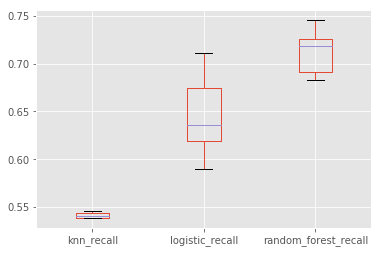

In [97]:
#VISUALIZATION OF THE PERFORMANCE METRICS

import numpy as np
import pandas as pd
lrg_recall=scores_M1['test_recall_macro']
knn_recall=scores_M2['test_recall_macro']
rfor_recall=scores_M3['test_recall_macro']
df_a = pd.DataFrame({'logistic_recall':lrg_recall, 'knn_recall':knn_recall, 'random_forest_recall':rfor_recall})
#df_a.plot('x', 'y', kind='scatter')
df_a.head()
print(type(df_a))


#boxplot
fig, ax = plt.subplots()
box = df_a.boxplot(ax=ax, sym='',return_type='dict') 
ax.margins(y=0.05)
plt.show()


> After running 10 CV scenarios for the best model under the 3 different methods (KNN neighbors, logistic regression, and Random forest), the random forest yields the highest recall. Therefore, the best classification model is the random forest.

# <a name="Advantages-of-each-model"></a>Advantages of each model
>[10 points] Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques — be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course


In [66]:
####### CREATE 10 FOLDS for the LOGISTIC REGRESSION with the corresponding acuracies

### WE RUN A LOGISTIC REGRESSION WITH THE BEST CONFIGURATION

#We set to the best regression configuration obtained
LogregEstimator = LogregGridSearch.best_estimator_




from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

scoring = ['precision_macro', 'recall_macro']
#clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores_M1 = cross_validate(LogregEstimator, X_c, y_c, scoring=scoring,
                         cv=10, return_train_score=False)
sorted(scores_M1.keys())
#['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']
scores_M1['test_recall_macro']                       





array([0.5902796 , 0.63883164, 0.61697077, 0.67066436, 0.68094983,
       0.61271714, 0.67569126, 0.6246933 , 0.63248886, 0.71097963])

In [73]:
######### CREATE 10 FOLDS for the KNN NEIGHBORS with the corresponding acuracies

clf_KNN = KNeighborsClassifier(n_neighbors=8, weights='uniform', metric='cosine')
scoring = ['precision_macro', 'recall_macro']

scores_M2 = cross_validate(clf_KNN, X_c, y_c, scoring=scoring,
                         cv=10, return_train_score=False)


scores_M2['test_recall_macro'] 

print(scores_M2['test_recall_macro'])



[0.52655036 0.53084611 0.54407521 0.54073805 0.53870276 0.54346582
 0.55363457 0.54025393 0.53897969 0.54630713]


In [93]:
####EXECUTING THE STATISTICAL COMPARISON

print(scores_M1['test_recall_macro'])

print(scores_M2['test_recall_macro'])

t = 2.26 / np.sqrt(10)

e = (1-scores_M1['test_recall_macro'])-(1-scores_M2['test_recall_macro'])

print(e)

stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (np.mean(scores_M1['test_recall_macro']), np.mean(scores_M2['test_recall_macro']))

[0.5902796  0.63883164 0.61697077 0.67066436 0.68094983 0.61271714
 0.67569126 0.6246933  0.63248886 0.71097963]
[0.52655036 0.53084611 0.54407521 0.54073805 0.53870276 0.54346582
 0.55363457 0.54025393 0.53897969 0.54630713]
[-0.06372924 -0.10798554 -0.07289556 -0.12992632 -0.14224707 -0.06925132
 -0.12205669 -0.08443937 -0.09350916 -0.1646725 ]
Range of: -0.12815868331170316 -0.08198387255029961
0.6454266394210967 0.5403553614900953


> The CI of 95% does not contain the value of ZERO, there is evidence to reject the fact that they are equal. Therefore, we can compare the metrics of performance between the models.

> Regarding the regression models, the capped multiple regression model has the lowest mean absolute error mean, which has an MAE value that is nearly identical to the ridge regression model.In regards to the classification models, KNN and Random Forest, the Random Forest model performed better based the accuracy, recall and F1 measurements. 



# <a name="Relevant-Attributes"></a>Relevant Attributes
>[10 points] Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task


KNN works best when there is low dimensionality, meaning not using hundreds of features, which could help explain why it performed so poorly on this data set.  Furthermore, normalizing your data so that each feature is on the same scale will create a better model. With this in mind, there are not features that are less or more important in a KNN model that we can find after the model has been run. The process of selecting features should be perfmored before the model is created. 

## Random Forest Classification

In [26]:
print(rf_feature_importance)

name                             score
PAY_1_range_delay > 1      0.372245
PAY_2_range_delay > 1      0.133365
PAY_3_range_delay > 1      0.125875
PAY_4_range_delay > 1      0.0834808
PAY_5_range_delay > 1      0.0722582
Avg_PAY                    0.047437
PAY_AMT1                   0.0218495
PAY_1_range_delay 1 month  0.0210993
AvgBill_to_LIMIT_BAL       0.0169963
PAY_6_range_delay > 1      0.0166988
Avg_BILL                   0.013718
BILL_AMT1                  0.0124861
LIMIT_BAL                  0.0119507
PAY_AMT2                   0.00795423
BILL_AMT6                  0.0056909
AvgPay_to_LIMIT_BAL        0.00550888
BILL_AMT5                  0.00491666
AGE                        0.0042173
PAY_AMT3                   0.00374077
BILL_AMT2                  0.00309771
PAY_AMT4                   0.00301231
BILL_AMT3                  0.00283783
PAY_AMT6                   0.00271931
PAY_AMT5                   0.00206288
EDUCATION_INP_4            0.00204503
BILL_AMT4                  0.00

# <a name="Deployment"></a>Deployment
>[5 points] How useful is your model for interested parties (i.e., the companies or organizations
that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

> For the classification task it is important to be able to identify potential delinquent customers. The model with the highest recall is the "Random forest". The bank will use the model to grant credit to existing and new customers.  The implementation of the model would be dependent on the bank's infraestucture to implement the random forest if the bank does not have a very flexible and to some extent up-to date infrastructure, it would be recommended to implement the logistic regression.  it is recommended to monitor the model on the quaterly basis to determine if it default rate remains according to bank's expectations, if that is not the case, the model will have to be revisited. The additional data to be included would come from social media to get to know more socioeconomic aspects of the borrowers.

> Finally for the regression task, predicting the "Ratio of average bill amount to credit limit balance" will allow the bank to offer additinal credit products to the ones that have lower usage of their credit. This model can be assesed on annual basis to determine if after offering a product to those customer with high usage, they accepted it and their usage moves to a level that provides a higher return to the bank.


# <a name="Exceptional-Work"></a>Exceptional Work
> [10 points] You have free reign to provide additional analyses
> One idea: grid search parameters in a parallelized fashion and visualize the
performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

For our exceptional work, we created additional variables as well as perfomed a grid search testing 40 models to find the best parameters for our Linear Regression model based on MAE.

# <a name="References"></a>References

* https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
* https://github.com/jakemdrew/EducationDataNC/blob/master/Graduation%20Rates%20v2.ipynb
* http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
* https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn
* http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
* https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
* http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
* https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/
* https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
* http://scikit-learn.org/stable/modules/cross_validation.html
